In [1]:
import os
import sys
# # Set GPU or CPU; -1: CPU
# 0, 1, 2, 3: GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# disable message output from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import tensorflow as tf
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from lorenz_data.data_generator import euler_sde
from lorenz_data.data_generator import euler
from lorenz_data.data_generator import euler_net
from lorenz_data.data_generator import data_generator
import onsagernet as onet

## Lorenz system

$$
\begin{aligned}
\frac{dX}{d\tau} & = -\sigma X +\sigma Y\\
\frac{dY}{d\tau} &= -XZ +rX -Y\\
\frac{dZ}{d\tau} &= XY-bZ\\\
\end{aligned}$$

#### Data generation

To generate sample data, we simulate the Lorenz systems using `solve_ivp` of the `scipy` package, and choose the method `RK45`. We sample $1000$ uniform random initial conditions $(x,y,z) \in [-1,1]^3$. 

For each trajectory, we evaluate the lorenz systems at $100$ pairs $(\frac{iT}{100},\frac{iT}{100}+\Delta t)$, here we choose $T = 10, \Delta t = 0.02$. The value of lorenz system at $\frac{iT}{100}$ are taken as X(input variables) of OnsagerNet, and the value at $\frac{iT}{100}+\Delta t$ are taken as Y(output variables) of OnsagerNet.

In [4]:
class Lorenz_generator(data_generator):
    """Autonomous Lorenz equation

        x'[t] = sigma * (y[t]-x[t]) 

        y'[t] = x[t] * (r-z[t]) - y[t]

        z'[t] = x[t] * y[t] - b * z[t]
    """    
    def __init__(self, T = 10,n_t =100, delta_t = 0.01, n_samples = 1000, n_dim = 3, sigma = 10, b = 8.0/3.0, r = 16):
        super(Lorenz_generator,self).__init__(T = T,n_t = n_t, delta_t = delta_t, n_samples = n_samples, n_dim = n_dim)
        self.sigma = sigma
        self.b = b
        self.r = r
        
    def f(self, t, u):
        return np.array([-self.sigma*u[0]+self.sigma*u[1],
                        -u[0]*u[2]+self.r*u[0]-u[1],
                        u[0]*u[1]-self.b*u[2]])


In [5]:
sigma = 10
b = 8.0/3.0
T = 10
delta_t = 0.02
n_features = 3
n_samples = 1000
n_t = 100 
region = [-1,1,-1,1,-1,1]
train_size = 0.6
valid_size = 0.2
test_size = 0.2

In [6]:
# r = 16
Lorenz_r16 = Lorenz_generator(T = T, n_t = n_t,delta_t = delta_t, n_samples = n_samples, 
                              n_dim = n_features, sigma = sigma, b = b, r = 16)
#X_data,Y_data  = Lorenz_r16.generate_data(region = region, fun = Lorenz_r16.f)
#np.savez('lorenz_data/Lorenz_r16.npz',X_data = X_data, Y_data  = Y_data)


# r = 28
Lorenz_r28 = Lorenz_generator(T = T, n_t = n_t, delta_t = delta_t, n_samples = n_samples, 
                              n_dim = n_features, sigma = sigma, b = b, r = 28)
#X_data,Y_data  = Lorenz_r28.generate_data(region = region, fun = Lorenz_r28.f)
#np.savez('lorenz_data/Lorenz_r28.npz',X_data = X_data, Y_data  = Y_data)

Let's have a look at the solution $(X,Y,Z)$ when $\sigma = 10, b = \frac{8}{3}, r = 16 \ \text{or} \ 28.$

Here we only show the phase plot of $(X,Y)$.

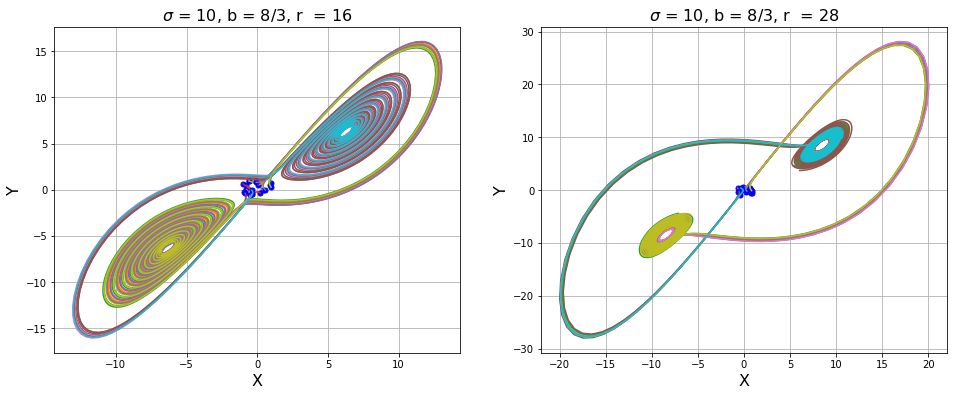

In [7]:
import random
random.seed(10)

fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)
T  = 10
for i in range(20):
    y0 = np.random.uniform(-1,1,3)
    axes.plot(y0[0],y0[1],'bo',markersize = 5)
    sol = solve_ivp(fun = Lorenz_r16.f, t_span = (0,T), y0 = y0, method = 'RK45',
                    rtol=1.e-8, atol=1.e-8, dense_output=True)
    t_eval = np.linspace(0, T, T*100)
    pred = sol.sol(t_eval).T
    axes.plot(pred[:,0],pred[:,1])
axes.set_title('$\sigma$ = 10, b = 8/3, r  = 16', fontsize = 16)
axes.set_xlabel('X', fontsize = 16)
axes.set_ylabel('Y', fontsize = 16)
axes.grid() 

axes = fig.add_subplot(1,2,2)
T  = 10
for i in range(20):
    y0 = np.random.uniform(-1,1,3)
    axes.plot(y0[0],y0[1],'bo',markersize = 5)
    sol = solve_ivp(fun = Lorenz_r28.f, t_span = (0,T), y0 = y0, method = 'RK45',
                    rtol=1.e-8, atol=1.e-8, dense_output=True)
    t_eval = np.linspace(0, T, T*100)
    pred = sol.sol(t_eval).T
    axes.plot(pred[:,0],pred[:,1])
axes.set_title('$\sigma$ = 10, b = 8/3, r  = 28', fontsize = 16)
axes.set_xlabel('X', fontsize = 16)
axes.set_ylabel('Y', fontsize = 16)
axes.grid()

plt.show()


#### OnsagerNet on Lorenz system with $r = 16$

In [8]:
# Load data

path = 'lorenz_data/Lorenz_r16.npz'
with np.load(path) as data:
    X_data = data['X_data']
    Y_data = data['Y_data']
X_train,X_valid,X_test,Y_train,Y_valid,Y_test = Lorenz_r16.train_test_split(X_data = X_data, Y_data = Y_data, 
                                                                train_size = train_size,valid_size = valid_size)

In [9]:
print('X_train shape:',X_train.shape)
print('X_valid shape:',X_valid.shape)
print('X_test shape',X_test.shape)

X_train shape: (60000, 3)
X_valid shape: (20000, 3)
X_test shape (20000, 3)


In [10]:
# Load NumPy arrays with tf.data.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,Y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test))


In [11]:
# Shuffle and batch the datasets

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
beta = 0.1
alpha = 0.01

pot_layer_size = [16,16,4,4]
dc_layer_sizes = [16,16,4]
fc_layer_sizes = [16,16,4,4]


In [13]:
# build Onsager net 
def build_onsager_net():
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.FCForcingNet(n_dim = n_features)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    inputs = tf.keras.Input((n_features,))
    outputs = onsager_net(inputs)
    onsager_rhs = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return onsager_rhs

In [14]:
model = onet.ODEOnsagerNet(n_features = n_features,delta_t = delta_t,OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

Model: "ode_onsager_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onsager_rhs (Functional)    (None, 3)                 1115      
                                                                 
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
_________________________________________________________________


In [15]:
# set learning rate
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss =tf.keras.losses.MeanSquaredError())

Let us have a look at the predicted trajectory by the model before training.

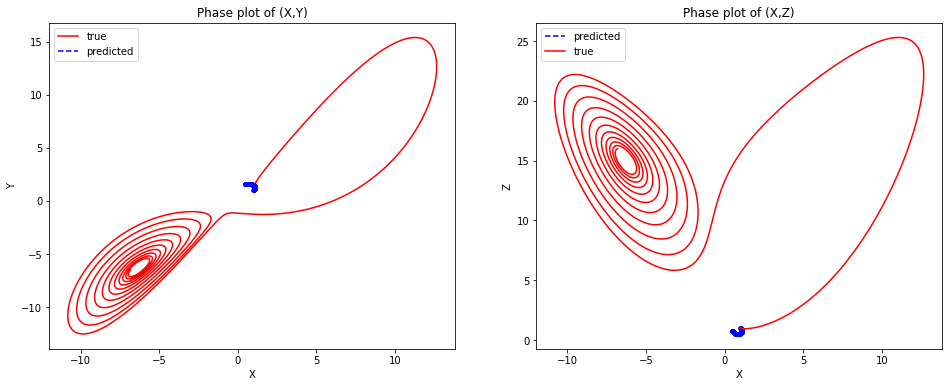

In [16]:
# multi-step predict
u0 = np.array([1,1,1])
drift = lambda u:Lorenz_r16.f(0,u)

fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)
t,u = euler(drift,u0 = u0, t_span = (0,10),N = 10000,n_dim = 3)
axes.plot(u[:,0],u[:,1],'r',label ='true')

t,u = euler_net(model,u0 = u0, delta_t = delta_t,N = 500,n_dim = 3)
axes.plot(u[:,0],u[:,1],'bo',markersize = 3)
axes.plot(u[:,0],u[:,1],'b--',label ='predicted')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('Phase plot of (X,Y)')
axes.legend()

axes = fig.add_subplot(1,2,2)
axes.plot(u[:,0],u[:,2],'bo',markersize = 3)
axes.plot(u[:,0],u[:,2],'b--',label ='predicted')
t,u = euler(drift,u0 = u0, t_span = (0,10),N = 10000,n_dim = 3)
axes.plot(u[:,0],u[:,2],'r',label ='true')
axes.set_xlabel('X')
axes.set_ylabel('Z')
axes.set_title('Phase plot of (X,Z)')

axes.legend()
plt.show()

In [17]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 2, min_lr = 1e-5)
history = model.fit(train_dataset,
                   validation_data = valid_dataset,
                   epochs = 20,
                   callbacks = lr)

Epoch 1/20
938/938 [==============================] - 11s 7ms/step - loss: 0.1771 - val_loss: 0.0173 - lr: 0.0010
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0653 - val_loss: 0.0170 - lr: 0.0010
Epoch 3/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0496 - val_loss: 0.0132 - lr: 0.0010
Epoch 4/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0384 - val_loss: 0.0100 - lr: 0.0010
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0299 - val_loss: 0.0089 - lr: 0.0010
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0235 - val_loss: 0.0077 - lr: 0.0010
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0191 - val_loss: 0.0062 - lr: 0.0010
Epoch 8/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0160 - val_loss: 0.0053 - lr: 0.0010
Epoch 9/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0137 - val_loss: 0.

In [18]:
# evaluate the model on the test dataset 
model.evaluate(test_dataset)

313/313 [==============================] - 1s 2ms/step - loss: 0.0013


0.0012564738281071186

Let us have a look at the loss.

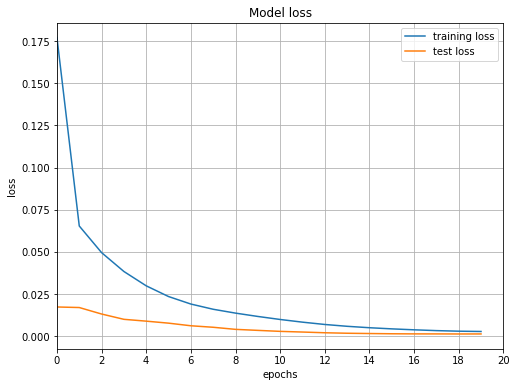

In [19]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(history.history['loss'],label = 'training loss')
axes.plot(history.history['val_loss'],label = 'test loss')
axes.set_title('Model loss')
axes.set_xlabel('epochs')
axes.set_ylabel('loss')
axes.set_xlim(0,20)
axes.set_xticks(np.linspace(0,20,11))
axes.grid()
axes.legend()
plt.show()

In [20]:
y_pred = model.predict(X_test).reshape(n_samples,-1)
y_true = Y_test.reshape(n_samples,-1)
mse = tf.keras.losses.mean_squared_error(y_true,y_pred)
mse = np.array(mse)
print(mse.shape)

625/625 [==============================] - 1s 2ms/step
(1000,)


We find the trajectory with the largest mean squared error first. The we explore the true trajectory and the predicted trajectory.

In [21]:
# find the trajectory with the largest mse

i = np.argmax(mse)
true_i = Y_data[i,:,:]
pred_i = model.predict(X_data[i,:,:])
err = pred_i - true_i

4/4 [==============================] - 0s 2ms/step


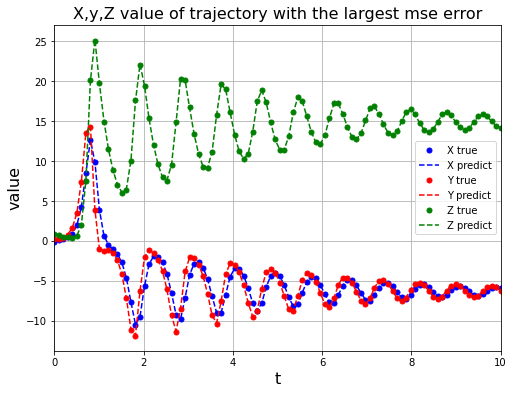

In [22]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
t = np.linspace(0,T,n_t)
axes.plot(t,true_i[:,0],'bo',label = 'X true',markersize = 5)
axes.plot(t,pred_i[:,0],'b--',label = 'X predict')
axes.plot(t,true_i[:,1],'ro',label = 'Y true',markersize = 5)
axes.plot(t,pred_i[:,1],'r--',label = 'Y predict')
axes.plot(t,true_i[:,2],'go',label = 'Z true',markersize = 5)
axes.plot(t,pred_i[:,2],'g--',label = 'Z predict')
axes.set_xlim(0,10)
axes.set_title('X,y,Z value of trajectory with the largest mse error',fontsize = 16)
axes.set_xlabel('t',fontsize = 16)
axes.set_ylabel('value',fontsize = 16)
axes.grid()
axes.legend()
plt.show()



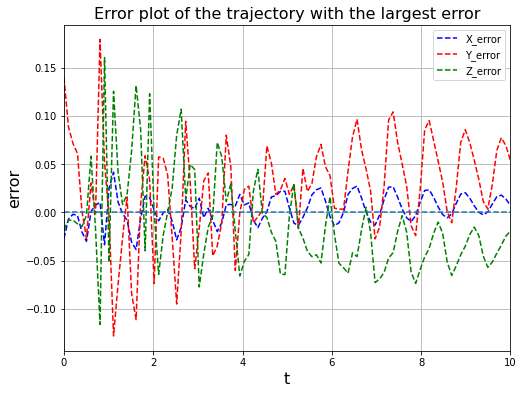

In [23]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
t = np.linspace(0,T,n_t)
axes.plot(t,err[:,0],'b--',label = 'X_error')
axes.plot(t,err[:,1],'r--',label = 'Y_error')
axes.plot(t,err[:,2],'g--',label = 'Z_error')
axes.plot(t,np.zeros(n_t),'--')
axes.set_xlim(0,10)
axes.set_title('Error plot of the trajectory with the largest error',fontsize = 16)
axes.set_xlabel('t',fontsize = 16)
axes.set_ylabel('error',fontsize = 16)
axes.grid()
axes.legend()
plt.show()



Next we choose two initial condition $(-0.1,-0.1,-0.1)$ and $(0.1,0.1,0.1)$. We  solve the lorenz system given the initial condition and plot the true trajectory and the predicted trajectory.

32/32 [==============================] - 0s 2ms/step


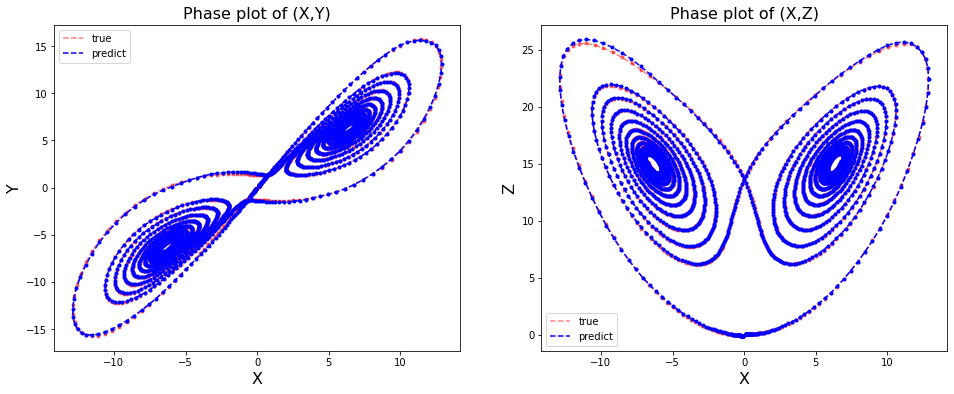

In [24]:
# one step predict
fig = plt.figure(figsize = (16,6))
Y0 = np.array([[-0.1,-0.1,-0.1],[0.1,0.1,0.1]])
name = ['X','Y','Z']
for j in range(2):
    axes = fig.add_subplot(1,2,j+1)
    for i in range(2):
        y0 = Y0[i,:]
        axes.plot(y0[0],y0[1],'ro',markersize = 3)
        sol = solve_ivp(fun = Lorenz_r16.f, t_span = (0,10), y0 = y0, method = 'RK45',
                        rtol=1.e-8, atol=1.e-8, dense_output=True)
        t_eval= np.linspace(0, 10, 1000)
        data = sol.sol(t_eval).T
        y_pred = model.predict(data) 
        t_eval = t_eval + delta_t
        true = sol.sol(t_eval).T
        
        axes.plot(true[:,0],true[:,j+1],'ro',alpha = 0.5,markersize = 3)
        axes.plot(true[:,0],true[:,j+1],'r--',alpha = 0.5,label = 'true')
        axes.plot(y_pred[:,0],y_pred[:,j+1],'bo',markersize = 3)
        axes.plot(y_pred[:,0],y_pred[:,j+1],'b--',label ='predict')
        if(i==0):
            axes.legend()
            axes.set_xlabel('X',fontsize = 16)
            axes.set_ylabel(name[j+1],fontsize = 16)
            axes.set_title('Phase plot of (X,{})'.format(name[j+1]),fontsize = 16)


plt.show()

Let us pedict the trajectory with initial condition $[1,1,1]$. Note that in our prediction, we only use one initial condition $[1,1,1]$, and use the output as input again, i.e., we predict multiste.

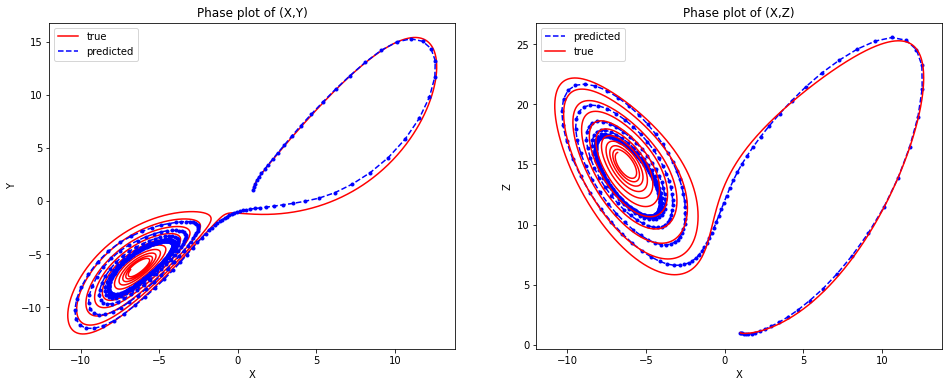

In [25]:
# multi-step predict
u0 = np.array([1,1,1])
drift = lambda u:Lorenz_r16.f(0,u)

fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)
t,u = euler(drift,u0 = u0, t_span = (0,10),N = 10000,n_dim = 3)
axes.plot(u[:,0],u[:,1],'r',label ='true')

t,u = euler_net(model,u0 = u0, delta_t = delta_t,N = 500,n_dim = 3)
axes.plot(u[:,0],u[:,1],'bo',markersize = 3)
axes.plot(u[:,0],u[:,1],'b--',label ='predicted')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('Phase plot of (X,Y)')
axes.legend()

axes = fig.add_subplot(1,2,2)
axes.plot(u[:,0],u[:,2],'bo',markersize = 3)
axes.plot(u[:,0],u[:,2],'b--',label ='predicted')
t,u = euler(drift,u0 = u0, t_span = (0,10),N = 10000,n_dim = 3)
axes.plot(u[:,0],u[:,2],'r',label ='true')
axes.set_xlabel('X')
axes.set_ylabel('Z')
axes.set_title('Phase plot of (X,Z)')

axes.legend()
plt.show()

The lorenz system is a chaotic system. Any small perturbation may cause huge deviation as time evolves. We can observe from the above pictures that the solution predicted by our OnsagerNet fit well with the high-precision numerical solution. Although at some points there is a small difference between the predicted solution and the tru solution, there general trajectory in the phase plot fit quite well.

#### OnsagerNet on Lorenz system with $r = 28$

In [26]:
# Load data

path = 'lorenz_data/Lorenz_r28.npz'
with np.load(path) as data:
    X_data = data['X_data']
    Y_data = data['Y_data']
X_train,X_valid,X_test,Y_train,Y_valid,Y_test = Lorenz_r28.train_test_split(X_data = X_data, Y_data = Y_data, 
                                                                train_size = train_size,valid_size = valid_size)

In [27]:
# Load NumPy arrays with tf.data.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,Y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test))

In [28]:
# Shuffle and batch the datasets

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [29]:
beta = 0.1
alpha = 0.01

pot_layer_size = [16,16,4,4]
dc_layer_sizes = [16,16,4]
fc_layer_sizes = [16,16,4,4]


In [31]:
# build OnsagerNet 
model = onet.ODEOnsagerNet(n_features = n_features,delta_t = delta_t,OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 2, min_lr = 1e-5)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss ='mse')
history = model.fit(train_dataset,
                   validation_data = valid_dataset,
                   epochs = 20,
                   callbacks = lr)

Epoch 1/20
938/938 [==============================] - 6s 4ms/step - loss: 0.2905 - val_loss: 0.0640 - lr: 0.0100
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1199 - val_loss: 0.0342 - lr: 0.0100
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0395 - val_loss: 0.0151 - lr: 0.0100
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0120 - val_loss: 0.0090 - lr: 0.0100
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0069 - val_loss: 0.0072 - lr: 0.0100
Epoch 6/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0053 - val_loss: 0.0061 - lr: 0.0100
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0045 - val_loss: 0.0074 - lr: 0.0100
Epoch 8/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0039 - val_loss: 0.0081 - lr: 0.0100
Epoch 9/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0029 - val_loss: 0.0

In [32]:
model.evaluate(test_dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.0090


0.009027579799294472

Let us have a look at the loss.

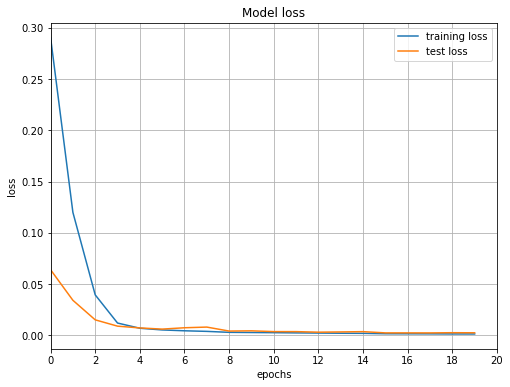

In [33]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(history.history['loss'],label = 'training loss')
axes.plot(history.history['val_loss'],label = 'test loss')
axes.set_title('Model loss')
axes.set_xlabel('epochs')
axes.set_ylabel('loss')
axes.set_xlim(0,20)
axes.set_xticks(np.linspace(0,20,11))
axes.grid()
axes.legend()
plt.show()

We find the trajectory with the largest mean squared error fiest. The we explore the true trajectory and the predicted trajectory.

In [34]:
# find the trajectory with the largest mse
i = np.argmax(mse)
true_i = Y_data[i,:,:]
pred_i = model.predict(X_data[i,:,:])
err = pred_i - true_i

4/4 [==============================] - 1s 2ms/step


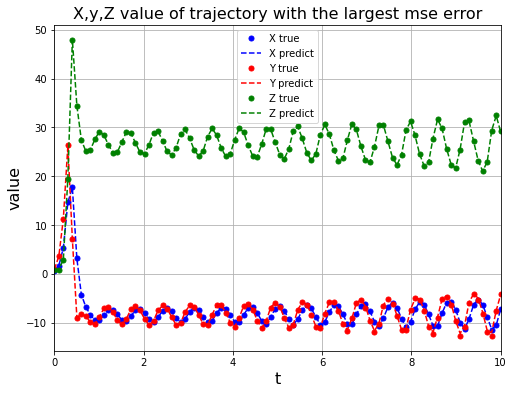

In [35]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
t = np.linspace(0,T,n_t)
axes.plot(t,true_i[:,0],'bo',label = 'X true',markersize = 5)
axes.plot(t,pred_i[:,0],'b--',label = 'X predict')
axes.plot(t,true_i[:,1],'ro',label = 'Y true',markersize = 5)
axes.plot(t,pred_i[:,1],'r--',label = 'Y predict')
axes.plot(t,true_i[:,2],'go',label = 'Z true',markersize = 5)
axes.plot(t,pred_i[:,2],'g--',label = 'Z predict')
axes.set_xlim(0,10)
axes.set_title('X,y,Z value of trajectory with the largest mse error',fontsize = 16)
axes.set_xlabel('t',fontsize = 16)
axes.set_ylabel('value',fontsize = 16)
axes.grid()
axes.legend()
plt.show()

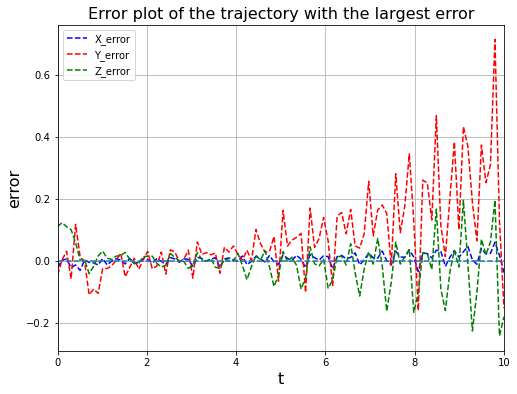

In [36]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
t = np.linspace(0,T,n_t)
axes.plot(t,err[:,0],'b--',label = 'X_error')
axes.plot(t,err[:,1],'r--',label = 'Y_error')
axes.plot(t,err[:,2],'g--',label = 'Z_error')
axes.plot(t,np.zeros(n_t),'--')
axes.set_xlim(0,10)
axes.set_title('Error plot of the trajectory with the largest error',fontsize = 16)
axes.set_xlabel('t',fontsize = 16)
axes.set_ylabel('error',fontsize = 16)
axes.grid()
axes.legend()
plt.show()

Next we choose two initial condition $(-0.1,-0.1,-0.1)$ and $(0.1,0.1,0.1)$. We  solve the lorenz system given the initial condition and plot the true trajectory and the predicted trajectory.

32/32 [==============================] - 0s 3ms/step


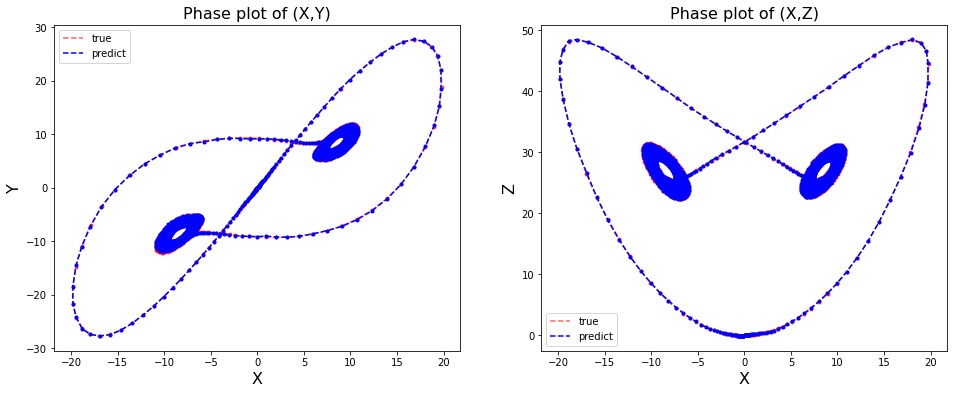

In [37]:
fig = plt.figure(figsize = (16,6))
Y0 = np.array([[-0.1,-0.1,-0.1],[0.1,0.1,0.1]])
name = ['X','Y','Z']
for j in range(2):
    axes = fig.add_subplot(1,2,j+1)
    for i in range(2):
        y0 = Y0[i,:]
        axes.plot(y0[0],y0[1],'ro',markersize = 3)
        sol = solve_ivp(fun = Lorenz_r28.f, t_span = (0,10), y0 = y0, method = 'RK45',
                        rtol=1.e-8, atol=1.e-8, dense_output=True)
        t_eval= np.linspace(0, 10, 1000)
        data = sol.sol(t_eval).T
        y_pred = model.predict(data) 
        t_eval = t_eval + delta_t
        true = sol.sol(t_eval).T
        
        axes.plot(true[:,0],true[:,j+1],'ro',markersize = 3,alpha = 0.6)
        axes.plot(true[:,0],true[:,j+1],'r--',alpha = 0.6,label = 'true')
        axes.plot(y_pred[:,0],y_pred[:,j+1],'bo',markersize = 3)
        axes.plot(y_pred[:,0],y_pred[:,j+1],'b--',label ='predict')
        if(i==0):
            axes.legend()
            axes.set_xlabel('X',fontsize = 16)
            axes.set_ylabel(name[j+1],fontsize = 16)
            axes.set_title('Phase plot of (X,{})'.format(name[j+1]),fontsize = 16)


plt.show()